# IMPORTS AND GENERAL FUNCTIONS

In [ ]:
# default_exp preprocessing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
import glob
import os
import chart_studio.plotly as py
import plotly.graph_objects as go

In [ ]:
#export
def re_assert_cod_datatypes(df):
    dtypes = {
        "COD_DPTO":"object",
        "COD_MUNICIPIO":"object",
        "SEMANA":"object",
        "ANO":"object",
        "DENGUE":"UInt16",
        "DENGUE GRAVE":"UInt16",
        "MORTALIDAD POR DENGUE":"UInt8",
        "CODIGOESTACION":"object"
    }
    for col in df.columns:
        if col in dtypes.keys():
            df[col] = df[col].astype(dtypes[col])
            if col == "SEMANA":
                df[col] = df[col].apply(lambda x: str(x).zfill(2))
    return df

In [ ]:
#export
def get_sivigila_calendar():
    date = pd.to_datetime("2006-01-01")
    week = 1
    weeks = []
    year = 2006
    sivigila_53_years = [2008, 2014, 2020]
    day = 1
    while year < 2021:
        if week == 53:
            if week == 53 and not (year in sivigila_53_years):
                week = 1
        elif week > 53:
            week = 1
        if day == 1:
            year = date.year
        weeks.append( (date,year,week) )
        day+=1
        if day==8:
            week += 1
            day = 1
        date += pd.DateOffset(days=1)
    columns = ["FECHA","ANO","SEMANA"]
    df_weeks = pd.DataFrame(weeks, columns=columns)
    df_weeks = df_weeks.set_index(df_weeks.FECHA)
    df_weeks = re_assert_cod_datatypes(df_weeks)
    del(df_weeks["FECHA"])
    return df_weeks

# EXTRACTING DENGUE DATA FROM SIVIGILA FILE YEARS 2007 to 2020

In [ ]:
#export
def unify_column_names_dengue(columns):
    new_columns = []
    for col in columns:
        if "evento" == col.lower():
            new_columns.append("NOMBRE")
        elif "cod_e" in col.lower():
            new_columns.append("COD_EVE")
        elif "cod_d" in col.lower():
            new_columns.append("COD_DPTO")
        elif "cod_m" in col.lower():
            new_columns.append("COD_MUNICIPIO")
        elif "dato" in col.lower() or "conteo" in col.lower():
            new_columns.append("TOTAL_CASOS")
        else:
            new_columns.append(col.upper())
    return new_columns



def get_dengue_weeks_from_rutinaria(filename, codes, sheet_num):
    df = pd.read_excel(filename, sheet_name = sheet_num)
    df.columns = unify_column_names_dengue(list(df.columns))
    df = df[~df["COD_DPTO"].isin([0,1])]
    df = df[df.COD_EVE.isin(codes)]
    df_pivoted = df.pivot_table(values = "TOTAL_CASOS", columns = "NOMBRE", index = ["ANO","COD_DPTO","COD_MUNICIPIO","SEMANA"]).reset_index()
    
    return df_pivoted


def read_all_rutinarias(codes = [210,220, 580]):
    dfs = []
    for year in range(2007,2019):
        print("Doing year ", year)
        filename = "local/data/rutinarias_dengue/rutinaria_{}.xlsx".format(year)
        df = get_dengue_weeks_from_rutinaria(filename, codes, sheet_num = 3)
        df = re_assert_cod_datatypes(df)
        
        dfs.append(df)
    df = pd.concat(dfs)
    df.columns.name = None
    return re_assert_cod_datatypes(df)

In [ ]:
df_calendar = get_sivigila_calendar()
df_calendar_weekly = get_sivigila_calendar().drop_duplicates(subset=["ANO","SEMANA"])

In [ ]:
df_dengue_2007_2018 = read_all_rutinarias()

Doing year  2007
Doing year  2008
Doing year  2009


KeyboardInterrupt: 

In [ ]:
df_dengue_2007_2018 = re_assert_cod_datatypes(df_dengue_2007_2018)

In [ ]:
def get_time_series_from_municipio_subset(subset_mun, event_col_n, cod_eve, year = 2019):
    weeks_year = {2019:52,2020:16}
    try:
        series_index = get_index_from_col_and_string(subset_mun, subset_mun.columns[event_col_n], cod_eve)
        series = list(subset_mun.loc[series_index,:][6:])
    except:
        series = [0]*weeks_year[year]
    return series
    
def get_index_from_col_and_string(df, col,string):
    return df[df.loc[:,col]==string].index[0]

In [ ]:
wb = pd.read_excel("local/data/rutinarias_dengue/rutinaria_2019.xlsx")
for col in wb.columns[3:4]:
    if np.sum(wb.loc[:,col].str.contains("CALI")):
        mun_col = col
        break       

lista_municipios = list(wb.loc[:,col].unique())
lista_municipios = lista_municipios[lista_municipios.index("* ANTIOQUIA. MUNICIPIO DESCONOCIDO"):]
lista_municipios = [ (lista_municipios[i],lista_municipios[i+1]) for i in range(0,len(lista_municipios),2) ]

## YEAR 2019

In [ ]:
def dataframe_from_dengue_series(series, value_name):
    cols = ["ANO","COD_DPTO","COD_MUNICIPIO"]+[str(i) for i in range(1,53)]
    df = pd.DataFrame(series).transpose()
    df.columns=cols
    df = pd.melt(df, id_vars = ["ANO","COD_DPTO","COD_MUNICIPIO"], var_name = "SEMANA", value_name=value_name)
    return df


dfs = []
for i,mun in enumerate(lista_municipios):
    index1_mun = get_index_from_col_and_string(wb, mun_col, mun[0])
    index2_mun = get_index_from_col_and_string(wb, mun_col, mun[1])
    subset_mun = wb.loc[index1_mun:index2_mun-1, :]
    subset_mun = subset_mun.iloc[:,:-1]
    if not (subset_mun.iloc[0,0] is np.nan):
        cod_depto = subset_mun.iloc[0,0]
    cod_municipio = str(cod_depto).zfill(2) + str(subset_mun.iloc[0,2]).zfill(3)
    den_mort_series = get_time_series_from_municipio_subset(subset_mun, 4 ,"580")
    dengue_series = get_time_series_from_municipio_subset(subset_mun, 4 ,"210")
    den_grave_series = get_time_series_from_municipio_subset(subset_mun, 4,"220")
    dengue_series = [2019, cod_depto, cod_municipio] + dengue_series
    den_mort_series = [2019, cod_depto, cod_municipio] + den_mort_series
    den_grave_series =  [2019, cod_depto, cod_municipio] + den_grave_series
    df_dengue = dataframe_from_dengue_series(dengue_series, value_name = "DENGUE")
    df_dengue_grave = dataframe_from_dengue_series(den_grave_series, value_name = "DENGUE GRAVE")
    df_den_mort = dataframe_from_dengue_series(den_mort_series, value_name = "MORTALIDAD POR DENGUE")
    df_dengue["DENGUE GRAVE"] = df_dengue_grave["DENGUE GRAVE"]
    df_dengue["MORTALIDAD POR DENGUE"]  = df_den_mort["MORTALIDAD POR DENGUE"]
    dfs.append(df_dengue)

df_dengue_2019 = pd.concat(dfs, axis = 0)
del dfs

In [ ]:
df_dengue_2019 = re_assert_cod_datatypes(df_dengue_2019)
df_dengue_2019.head()

,ANO,COD_DPTO,COD_MUNICIPIO,SEMANA,DENGUE,DENGUE GRAVE,MORTALIDAD POR DENGUE
0,2019,05,05000,01,0,0,0
1,2019,05,05000,02,0,0,0
2,2019,05,05000,03,1,0,0
3,2019,05,05000,04,0,0,0
4,2019,05,05000,05,0,0,0


## YEAR 2020

In [ ]:
wb = pd.read_excel("local/data/rutinarias_dengue/rutinaria_2020.xlsx", sheet_name = 1)

In [ ]:
wb = wb.iloc[2:,2:]

for col in wb.columns[3:4]:
    if np.sum(wb.loc[:,col].str.contains("CALI")):
        mun_col = col
        break     
mun_col
lista_municipios = list(wb.loc[:,col].unique())

lista_municipios = lista_municipios[lista_municipios.index("* ANTIOQUIA. MUNICIPIO DESCONOCIDO"):]
lista_municipios = [ (lista_municipios[i],lista_municipios[i+1]) for i in range(0,len(lista_municipios),2) ]

In [ ]:
def dataframe_from_dengue_series(series, value_name):
    cols = ["ANO","COD_DPTO","COD_MUNICIPIO"]+[str(i) for i in range(1,17)]
    df = pd.DataFrame(series).transpose()
    df.columns=cols
    df = pd.melt(df, id_vars = ["ANO","COD_DPTO","COD_MUNICIPIO"], var_name = "SEMANA", value_name=value_name)
    return df
dfs = []
for i,mun in enumerate(lista_municipios):
    index1_mun = get_index_from_col_and_string(wb, mun_col, mun[0])
    index2_mun = get_index_from_col_and_string(wb, mun_col, mun[1])
    subset_mun = wb.loc[index1_mun:index2_mun-1, :]
    subset_mun = subset_mun.iloc[:,:-1]
    if not (subset_mun.iloc[0,0] is np.nan):
        cod_depto = subset_mun.iloc[0,0]
    cod_municipio = str(cod_depto).zfill(2) + str(subset_mun.iloc[0,2]).zfill(3)
    den_mort_series = get_time_series_from_municipio_subset(subset_mun, 4 ,"580", 2020)
    dengue_series = get_time_series_from_municipio_subset(subset_mun, 4 ,"210", 2020)
    den_grave_series = get_time_series_from_municipio_subset(subset_mun, 4,"220",2020)
    dengue_series = [2020, cod_depto, cod_municipio] + dengue_series
    den_mort_series = [2020, cod_depto, cod_municipio] + den_mort_series
    den_grave_series =  [2020, cod_depto, cod_municipio] + den_grave_series
    df_dengue = dataframe_from_dengue_series(dengue_series, value_name = "DENGUE")
    df_dengue_grave = dataframe_from_dengue_series(den_grave_series, value_name = "DENGUE GRAVE")
    df_den_mort = dataframe_from_dengue_series(den_mort_series, value_name = "MORTALIDAD POR DENGUE")
    df_dengue["DENGUE GRAVE"] = df_dengue_grave["DENGUE GRAVE"]
    df_dengue["MORTALIDAD POR DENGUE"]  = df_den_mort["MORTALIDAD POR DENGUE"]
    dfs.append(df_dengue)
df_dengue_2020 = pd.concat(dfs, axis = 0)
del dfs

In [ ]:
df_dengue_2020 = re_assert_cod_datatypes(df_dengue_2020)
df_dengue_2020.head()

,ANO,COD_DPTO,COD_MUNICIPIO,SEMANA,DENGUE,DENGUE GRAVE,MORTALIDAD POR DENGUE
0,2020,05,05000,01,0,0,0
1,2020,05,05000,02,0,0,0
2,2020,05,05000,03,0,0,0
3,2020,05,05000,04,0,0,0
4,2020,05,05000,05,0,0,0


In [ ]:
df_dengue_2007_2020 = pd.concat([df_dengue_2007_2018, df_dengue_2019, df_dengue_2020])
df_dengue_2007_2020 = re_assert_cod_datatypes(df_dengue_2007_2020)
df_dengue_2007_2020["COD_MUNICIPIO"] = df_dengue_2007_2020["COD_MUNICIPIO"].apply(lambda x: str(x).zfill(5))

In [ ]:
df_dengue_2007_2020

,ANO,COD_DPTO,COD_MUNICIPIO,SEMANA,DENGUE,DENGUE GRAVE,MORTALIDAD POR DENGUE
0,2007,5,05000,02,1,<NA>,<NA>
1,2007,5,05000,03,<NA>,2,<NA>
2,2007,5,05000,04,4,<NA>,<NA>
3,2007,5,05000,05,11,<NA>,<NA>
4,2007,5,05000,06,4,2,<NA>
...,...,...,...,...,...,...,...
11,2020,99,99773,12,0,0,0
12,2020,99,99773,13,1,0,0
13,2020,99,99773,14,0,0,0
14,2020,99,99773,15,0,0,0


In [ ]:
def get_composite_city_code(x):
    dept_code = x["COD_DPTO"]
    city_code = x["COD_MUNICIPIO"]
    composite_code = str(x["COD_DPTO"]).zfill(2) + str(x["COD_MUNICIPIO"]).zfill(3) 
    x["COD_MUNICIPIO"] = composite_code
    return x 
df_cities = pd.read_csv("local/data/DepartamentosMunicipios.csv")[["COD_DPTO","COD_MUNICIPIO"]]
df_cities = df_cities[~df_cities["COD_DPTO"].isin([0,1])]
df_cities = df_cities.apply(get_composite_city_code, axis = 1)
df_cities.head(1)

,COD_DPTO,COD_MUNICIPIO
0,91,91000


In [ ]:
def combine_cities_and_weeks(df_weeks, df_cities):
    dfs_week_city = []
    for city in df_cities.iterrows():
        df_week_city = df_weeks.copy()
        df_week_city["COD_MUNICIPIO"] = city[1][1]
        df_week_city["COD_DPTO"] = city[1][0]
        dfs_week_city.append(df_week_city)
    res = pd.concat(dfs_week_city, axis = 0)
    return res
df_weeks_cities = combine_cities_and_weeks(df_calendar_weekly, df_cities)
df_weeks_cities["COD_MUNICIPIO"] = df_weeks_cities["COD_MUNICIPIO"].apply(lambda x: str(x).zfill(5))
df_dengue_2007_2020["COD_MUNICIPIO"] = df_dengue_2007_2020["COD_MUNICIPIO"].apply(lambda x: str(x).zfill(5))
df_weeks_cities["SEMANA"] = df_weeks_cities["SEMANA"].apply(lambda x: str(x).zfill(2))
df_dengue_2007_2020["SEMANA"] = df_dengue_2007_2020["SEMANA"].apply(lambda x: str(x).zfill(2))
df_weeks_cities["ANO"] = df_weeks_cities["ANO"].apply(lambda x: str(x).zfill(4))
df_dengue_2007_2020["ANO"] = df_dengue_2007_2020["ANO"].apply(lambda x: str(x).zfill(4))
df_weeks_cities = re_assert_cod_datatypes(df_weeks_cities)
df_weeks_cities.tail(1)

,ANO,SEMANA,COD_MUNICIPIO,COD_DPTO
FECHA,,,,
2021-01-03,2021,01,99624,99


In [ ]:
def combine_cities_weeks_and_dengue(df_weeks_cities, df_dengue):
    den_columns = ["ANO","SEMANA","COD_DPTO","COD_MUNICIPIO","DENGUE", "DENGUE GRAVE", "MORTALIDAD POR DENGUE"]
    res = pd.merge(left=df_weeks_cities.reset_index(), 
                   right = df_dengue[den_columns], 
                   how = "left", 
                   on = ["ANO","SEMANA","COD_MUNICIPIO"],
                   suffixes=('', '_y')
                  )

    res = res.drop(res.filter(regex='_y$').columns.tolist(),axis=1)
    res = res.set_index("FECHA")
    return res
df_dengue_city_week = combine_cities_weeks_and_dengue(df_weeks_cities, df_dengue_2007_2020)
df_dengue_city_week = df_dengue_city_week.fillna(0)

In [ ]:
df_dengue_city_week.head()

,ANO,SEMANA,COD_MUNICIPIO,COD_DPTO,DENGUE,DENGUE GRAVE,MORTALIDAD POR DENGUE
FECHA,,,,,,,
2006-01-01,2006,01,91000,91,0,0,0
2006-01-08,2006,02,91000,91,0,0,0
2006-01-15,2006,03,91000,91,0,0,0
2006-01-22,2006,04,91000,91,0,0,0
2006-01-29,2006,05,91000,91,0,0,0


In [ ]:
df_dengue_city_week.to_csv("local/data/DENGUE_SEMANAL_CONSOLIDADO.csv", index = True)

# METEREOLOGICAL DATA

In [ ]:
#export
def read_csv_IDEAM(filenames, sep = r","):
    """
    This function receives a list of .csv files downloaded from http://dhime.ideam.gov.co/atencionciudadano/ 
    and combines information into a single pandas dataframe by keeping only the date and the relevant data column.
    
    -filenames: list of one or more filenames of .csv files.
    -codigo_estacion: the code of the station we are interested in.
    -sep: the kind of separation used for pd.read_csv, it is good to try and switch between ; and , if there is any trouble since
          the not all files downloaded from IDEAM have the same separator.
          
    returns: a dataframe with the datetime column as it index, and the V
    """
    dfs = []
    for filename in filenames:
        dfs.append(pd.read_csv(filename, sep, dtype={'Calificador': 'object','Latitud': 'object'}))
    if len(dfs) > 0:
        df = pd.concat(dfs, axis = 0).reset_index(drop=True)
    else:
        df = dfs[0]
    return df

def get_variable_IDEAM(df, possible_var_names, standard_var_name, codigo_estacion = None):
    df = df[df["Etiqueta"].isin(possible_var_names)].reset_index(drop=True)
    value_name = df.loc[0,"Etiqueta"]
    if codigo_estacion:
        df = df[(df["CodigoEstacion"] == codigo_estacion)]
    df = df[["CodigoEstacion","Fecha","Valor"]]
    df.columns = ["CodigoEstacion","DATE",standard_var_name]
    df.index = pd.to_datetime(df["DATE"], dayfirst = False)
    df = df.drop_duplicates()
    del(df["DATE"])
    return df

def filter_entries_by_column_index_values(df, column_name, min_val = None, max_val = None):
    if min_val and max_val:
        df = df[(df[column_name] >= min_val) & (df[column_name] <= max_val) ]
        return df
    elif not min_val:
        df = df[(df[column_name] <= max_val) ]
        return df
    elif not max_val:
        df = df[(df[column_name] >= min_val) ]
        return df
    else:
        return df
    
def combine_IDEAM_stations(df_all, stations_priority):
    df_st = df_all[df_all["CodigoEstacion"]==stations_priority[0]]
    if len(df_all) == 1:
        return df_st
    for station in stations_priority[1:]:
        df_st_add = df_all[df_all["CodigoEstacion"]==station]
        df_st_add = df_st_add[(~df_st_add.index.isin(df_st.index))]
        df_st = pd.concat([df_st, df_st_add])
    del df_st["CodigoEstacion"]
    return df_st

def aggregate_data(df, agg_type = 'daily', aggregations = [np.mean, np.max, np.min, 'count'], min_count = None):
    if agg_type == 'daily':
        df_aggregated = df.groupby([df.index.date]).agg(aggregations)
        df_aggregated.columns = ["_".join(x).upper() for x in df_aggregated.columns.ravel()]
        if min_count:
            df_aggregated = df_aggregated[(df_aggregated.iloc[:,-1] >= min_count)]
        df_aggregated.index = pd.to_datetime(df_aggregated.index)
    return df_aggregated.iloc[:,:-1]

def drop_duplicates_by_date_station(df):
    df = df.reset_index() 
    df = df.drop_duplicates(subset=["DATE","CodigoEstacion"])
    df = df.set_index("DATE")
    return df


# Workflow con datos del mapa del IDEAM

Poner en una única carpeta todos los archivos descargados para una ubicación dada.

Estoy trabajando en lograr que las descargas de la API queden con los mismos campos que las del IDEAM.

Las variables son: 

- "HRA2_AUT_60" <- HUMEDAD RELATIVA A 2 METROS, HORARIA
- "TA2_AUT_60" <- TEMPERATURA A 2 METROS, HORARIA
- "PTPM_CON" <- PRECIPITACIÓN, DIARIA

In [ ]:
municipality_name = "CUCUTA"
foldername = "./local/data/CUCUTA_IDEAM/"
filenames = sorted(glob.glob(foldername+'*.csv'))
df = read_csv_IDEAM(filenames).drop_duplicates()
df.head(1)
df.columns

Index(['CodigoEstacion', 'NombreEstacion', 'Latitud', 'Longitud', 'Altitud',
       'Categoria', 'Entidad', 'AreaOperativa', 'Departamento', 'Municipio',
       'FechaInstalacion', 'FechaSuspension', 'IdParametro', 'Etiqueta',
       'DescripcionSerie', 'Frecuencia', 'Fecha', 'Valor', 'Grado',
       'Calificador', 'NivelAprobacion'],
      dtype='object')

In [ ]:
df.drop_duplicates(subset=["CodigoEstacion"])

,CodigoEstacion,NombreEstacion,Latitud,Longitud,Altitud,Categoria,Entidad,AreaOperativa,Departamento,Municipio,...,FechaSuspension,IdParametro,Etiqueta,DescripcionSerie,Frecuencia,Fecha,Valor,Grado,Calificador,NivelAprobacion
0,16015501,AEROPUERTO CAMILO DAZA - AUT [16015501],7.9316111110,-72.511250,313.0,Sinóptica Principal,INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...,Area Operativa 08 - Santanderes-Arauca,Norte De Santander,Cúcuta,...,NaN,HUM RELATIVA,HRA2_AUT_60,Humedad relativa del aire a 2 metros horaria,Horaria,2015-10-05 11:00,38.0,50.0,NaN,900.0
34452,16015110,UNIVERSIDAD FRANCISO DE PAULA SANTANDER - AUT ...,7.8987777780,-72.487167,311.0,Climática Principal,INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...,Area Operativa 08 - Santanderes-Arauca,Norte De Santander,Cúcuta,...,NaN,HUM RELATIVA,HRA2_AUT_60,Humedad relativa del aire a 2 metros horaria,Horaria,2005-09-09 18:00,58.0,50.0,NaN,900.0
139834,16015010,AEROPUERTO CAMILO DAZA [16015010],7.9302777780,-72.509167,250.0,Sinóptica Principal,INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...,Area Operativa 08 - Santanderes-Arauca,Norte De Santander,Cúcuta,...,NaN,PRECIPITACION,PTPM_CON,Día pluviométrico,Diaria,2006-01-01 00:00,0.0,50.0,NaN,900.0
143404,16020320,AGUABLANCA [16020320],8.0361111110,-72.483611,250.0,Pluviométrica,INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...,Area Operativa 08 - Santanderes-Arauca,Norte De Santander,Cúcuta,...,04/10/2013 00:00,PRECIPITACION,PTPM_CON,Día pluviométrico,Diaria,2006-01-01 00:00,0.0,50.0,NaN,900.0
144890,16020140,BOCATOMA RIO ZULIA [16020140],8.0773333330,-72.583889,150.0,Pluviométrica,INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...,Area Operativa 08 - Santanderes-Arauca,Norte De Santander,Cúcuta,...,NaN,PRECIPITACION,PTPM_CON,Día pluviométrico,Diaria,2006-01-01 00:00,1.0,50.0,NaN,900.0
150066,16025010,CARMEN DE TONCHALA [16025010],7.8488888890,-72.566111,285.0,Climática Principal,INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...,Area Operativa 08 - Santanderes-Arauca,Norte De Santander,Cúcuta,...,NaN,PRECIPITACION,PTPM_CON,Día pluviométrico,Diaria,2006-01-01 00:00,0.0,50.0,NaN,900.0
155303,16010060,JARRA LA [16010060],8.2019444440,-72.432222,87.0,Pluviométrica,INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...,Area Operativa 08 - Santanderes-Arauca,Norte De Santander,Cúcuta,...,NaN,PRECIPITACION,PTPM_CON,Día pluviométrico,Diaria,2006-01-01 00:00,0.0,50.0,NaN,900.0
160293,16010100,RICAURTE [16010100],8.0263611110,-72.353972,1492.0,Pluviométrica,INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...,Area Operativa 08 - Santanderes-Arauca,Norte De Santander,Cúcuta,...,NaN,PRECIPITACION,PTPM_CON,Día pluviométrico,Diaria,2006-01-01 00:00,0.0,50.0,NaN,900.0
165242,16010340,TASAJERO [16010340],7.9930277780,-72.461722,953.0,Pluviométrica,INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...,Area Operativa 08 - Santanderes-Arauca,Norte De Santander,Cúcuta,...,NaN,PRECIPITACION,PTPM_CON,Día pluviométrico,Diaria,2006-01-01 00:00,0.0,50.0,NaN,900.0
349539,16025040,CINERA-VILLA OLGA,8.167777778,-72.468611,NaN,%,NaN,CATATUMBO,NORTE DE SANTANDER,CÚCUTA,...,NaN,NaN,Humedad del aire 2 mt,NaN,NaN,2019-07-23T15:00:00.000,69.0,NaN,NaN,NaN


# Workflow precipitación

1. Lectura y visualización inicial:

In [ ]:
standard_var_name = "PRECIPITACION"
possible_prec_names = ["PTPM_CON","Precipitacion"]
df_prec = get_variable_IDEAM(df, possible_prec_names, standard_var_name)

In [ ]:
df_prec = drop_duplicates_by_date_station(df_prec)

In [ ]:
df_prec

,CodigoEstacion,PRECIPITACION
DATE,,
2006-01-01,16015010,0.0
2006-01-02,16015010,0.0
2006-01-03,16015010,35.5
2006-01-04,16015010,66.2
2006-01-05,16015010,73.9
...,...,...
2020-06-23,16025040,0.0
2020-06-24,16025040,0.0
2020-06-25,16025040,0.0


In [ ]:
fig = go.Figure()
for df_group in df_prec.groupby("CodigoEstacion"):
    codigoestacion, df_gr = df_group
    df_gr = df_gr.resample('D').mean()
    plot_lluvia = go.Scatter(x=df_gr.index,
                y=df_gr[standard_var_name], name ="PP "+str(codigoestacion), mode = "lines")
    fig.add_trace(plot_lluvia)
layout = go.Layout(title="DAILY " +standard_var_name + " IN " + municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='PP'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

In [ ]:
# TO DO, ensure that the time series are daily no matter what the original resolution
df_prec_daily = df_prec

2. Combinación de estaciones por orden de prioridad: Aquí la idea es que una vez hecho el análisis de arriba seleccionemos los códigos de estaciones más relevantes para juntar.

In [ ]:
stations_priority = [16015010,16025010,16010340,16020320, 16025040]
df_prec_daily = combine_IDEAM_stations(df_prec_daily, stations_priority).sort_index()
df_prec_daily = df_prec_daily.resample('D').mean()


In [ ]:
fig = go.Figure()
plot_lluvia = go.Scatter(x=df_prec_daily.index,
            y=df_prec_daily[standard_var_name], name ="PP "+str(codigoestacion), mode = "lines")
fig.add_trace(plot_lluvia)
layout = go.Layout(title="DAILY "+standard_var_name+" IN "+municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='PP'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

3. Variables compuestas o derivadas de los valores diarios

In [ ]:
threshold_dry = 0.1 # Characteristics of consecutive dry days variations in China (2016)
df_prec_daily["DRY_DAY"] = df_prec_daily[standard_var_name].apply(lambda x: True if x < 0.1 else False)
df_prec_daily.head()

,PRECIPITACION,DRY_DAY
DATE,,
2006-01-01,0.0,True
2006-01-02,0.0,True
2006-01-03,35.5,False
2006-01-04,66.2,False
2006-01-05,73.9,False


# Workflow temperatura

In [ ]:
standard_var_name = "TEMPERATURE"
possible_temp_names = ["TA2_AUT_60", "Temp Aire 2 m"]
df_temp = get_variable_IDEAM(df, possible_temp_names, standard_var_name).sort_index()
df_temp = drop_duplicates_by_date_station(df_temp)
df_temp

,CodigoEstacion,TEMPERATURE
DATE,,
2005-09-09 18:00:00,16015110,16.8
2005-09-09 19:00:00,16015110,16.1
2005-09-09 20:00:00,16015110,15.9
2005-09-09 21:00:00,16015110,15.4
2005-09-09 22:00:00,16015110,14.8
...,...,...
2020-06-27 22:00:00,16025040,25.8
2020-06-27 22:00:00,16015110,27.4
2020-06-27 23:00:00,16025040,25.5


1. En este for se agregan por día los datos de cada estación. Es importante ajustar el min_count según la frecuencia de las mediciones. Yo tengo que intentar ajustar este código para que auto-detecte la frecuencia y se puedan combinar fácil series de distintas granularidades.

In [ ]:
dfs = []
for codigoestacion in df_temp["CodigoEstacion"].unique():
    df_temp_est = df_temp[df_temp["CodigoEstacion"]==codigoestacion].iloc[:,-1:]
    df_temp_est = filter_entries_by_column_index_values(df_temp_est, standard_var_name, 12.5,40) # ELIMINACIÓN DE OUTLIERS EN LOS DATOS HORARIOS
    df_temp_est = aggregate_data(df_temp_est, agg_type='daily', min_count = 12).sort_index()   # ELIMINACIÓN DE DÍAS SIN SUFICIENTES OBSERVACIONES
    columns = ["CodigoEstacion"] + list(df_temp_est.columns)
    df_temp_est["CodigoEstacion"] = codigoestacion
    df_temp_est = df_temp_est[columns]
    dfs.append(df_temp_est)
df_temp_daily = pd.concat(dfs, axis = 0)

In [ ]:
fig = go.Figure()
for df_group in df_temp_daily.groupby("CodigoEstacion"):
    codigoestacion, df_gr = df_group
    df_gr = df_gr.resample('D').mean()
    plot_temp = go.Scatter(x=df_gr.index,
                y=df_gr[standard_var_name+"_MEAN"], name ="TEMP "+str(codigoestacion), mode = "lines", connectgaps= None)
    fig.add_trace(plot_temp)
    
layout = go.Layout(title="DAILY "+standard_var_name+" IN CUCUTA",
                xaxis=dict(title='DATE'),
                yaxis=dict(title='TEMP'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

2. Combinación de estaciones por orden de prioridad: Aquí la idea es que una vez hecho el análisis de arriba seleccionemos los códigos de estaciones más relevantes para juntar.



In [ ]:
stations_priority = [16015110,16015501]
df_temp_daily = combine_IDEAM_stations(df_temp_daily, stations_priority).sort_index()
df_temp_daily = df_temp_daily.resample('D').mean()

In [ ]:
fig = go.Figure()
plot_temp = go.Scatter(x=df_temp_daily.index,
            y=df_temp_daily[standard_var_name+"_MEAN"], name ="CC", mode = "lines")
fig.add_trace(plot_temp)
layout = go.Layout(title="DAILY "+standard_var_name+" IN "+municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='°C'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

3. Variables compuestas o derivadas de los valores diarios

In [ ]:
df_temp_daily[standard_var_name+"_RANGE"] = df_temp_daily[standard_var_name+"_AMAX"]  - df_temp_daily[standard_var_name+"_AMIN"] 
df_temp_daily.head()

,TEMPERATURE_MEAN,TEMPERATURE_AMAX,TEMPERATURE_AMIN,TEMPERATURE_RANGE
2005-09-10,20.82500,24.2,14.4,9.8
2005-09-11,18.53125,27.7,14.6,13.1
2005-09-12,NaN,NaN,NaN,NaN
2005-09-13,19.70000,26.0,13.4,12.6
2005-09-14,NaN,NaN,NaN,NaN


# Workflow humedad

In [ ]:
standard_var_name = "REL_HUMIDITY"
possible_hum_names = ["HRA2_AUT_60","Humedad del aire 2 mt"]
df_hum = get_variable_IDEAM(df, possible_hum_names, standard_var_name).sort_index()
df_hum = drop_duplicates_by_date_station(df_hum)
df_hum

,CodigoEstacion,REL_HUMIDITY
DATE,,
2005-09-09 18:00:00,16015110,58.0
2005-09-09 19:00:00,16015110,60.0
2005-09-09 20:00:00,16015110,62.0
2005-09-09 21:00:00,16015110,65.0
2005-09-09 22:00:00,16015110,66.0
...,...,...
2020-06-27 22:00:00,16015501,78.0
2020-06-27 22:00:00,16015110,76.0
2020-06-27 23:00:00,16025040,87.0


1. En este for se agregan por día los datos de cada estación. Es importante ajustar el min_count según la frecuencia de las mediciones. Yo tengo que intentar ajustar este código para que auto-detecte la frecuencia y se puedan combinar fácil series de distintas granularidades.

In [ ]:
dfs = []
for codigoestacion in df_hum["CodigoEstacion"].unique():
    df_hum_est = df_hum[df_hum["CodigoEstacion"]==codigoestacion].iloc[:,-1:]
    df_hum_est = filter_entries_by_column_index_values(df_hum_est, standard_var_name, 20) # ELIMINACIÓN DE OUTLIERS EN LOS DATOS HORARIOS
    df_hum_est = aggregate_data(df_hum_est, agg_type='daily', min_count = 12).sort_index()   # ELIMINACIÓN DE DÍAS SIN SUFICIENTES OBSERVACIONES
    columns = ["CodigoEstacion"] + list(df_hum_est.columns)
    df_hum_est["CodigoEstacion"] = codigoestacion
    df_hum_est = df_hum_est[columns]
    dfs.append(df_hum_est)
df_hum_daily = pd.concat(dfs, axis = 0)
df_hum_daily.head()

,CodigoEstacion,REL_HUMIDITY_MEAN,REL_HUMIDITY_AMAX,REL_HUMIDITY_AMIN
2005-09-10,16015110,44.166667,61.0,36.0
2005-09-11,16015110,54.437500,64.0,36.0
2005-09-13,16015110,54.230769,75.0,38.0
2005-09-28,16015110,77.541667,93.0,53.0
2005-12-29,16015110,79.125000,96.0,57.0


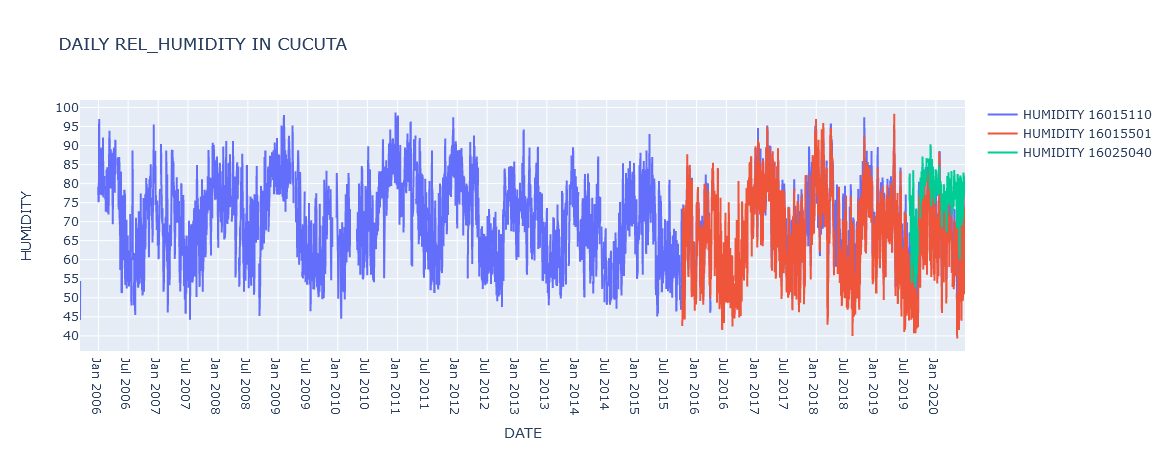

In [ ]:
fig = go.Figure()
for df_group in df_hum_daily.groupby("CodigoEstacion"):
    codigoestacion, df_gr = df_group
    df_gr = df_gr.resample('D').mean()
    plot_temp = go.Scatter(x=df_gr.index,
                y=df_gr[standard_var_name+"_MEAN"], name ="HUMIDITY "+str(codigoestacion), mode = "lines", connectgaps= None)
    fig.add_trace(plot_temp)
    
layout = go.Layout(title="DAILY "+standard_var_name+" IN CUCUTA",
                xaxis=dict(title='DATE'),
                yaxis=dict(title='HUMIDITY'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

2. Combinación de estaciones por orden de prioridad: Aquí la idea es que una vez hecho el análisis de arriba seleccionemos los códigos de estaciones más relevantes para juntar.



In [ ]:
stations_priority = [16015110,16015501]
df_hum_daily = combine_IDEAM_stations(df_hum_daily, stations_priority).sort_index()
df_hum_daily = df_hum_daily.resample('D').mean()

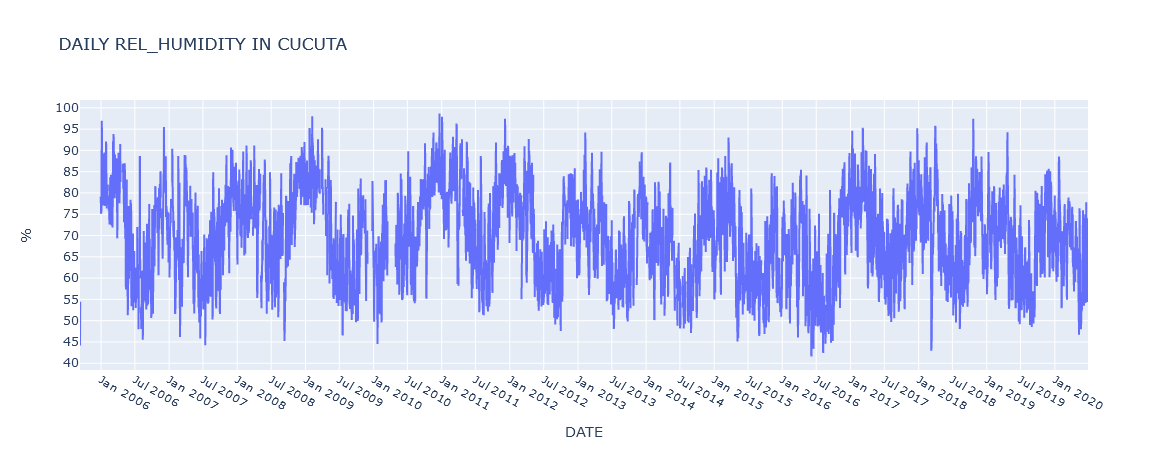

In [ ]:
fig = go.Figure()
plot_hum = go.Scatter(x=df_hum_daily.index,
            y=df_hum_daily[standard_var_name+"_MEAN"], name ="HUM", mode = "lines")
fig.add_trace(plot_hum)
layout = go.Layout(title="DAILY "+standard_var_name+" IN "+municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='%'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()